In [1]:
import numpy as np
import sd as SD
import pickle
import metrics as M
import matplotlib.pyplot as plt
import plot_metrics as PM
import seaborn as sns
from tqdm import tqdm

sns.set_theme(style="whitegrid", context="talk")


In [2]:
with open("lines.pickle", "rb") as f: # 'rb' for read binary
    lines = pickle.load(f)

In [3]:
NUM_CREWS = 30
NUM_LINES = len(lines)
NUM_FEATURES = 3

F = np.zeros((NUM_FEATURES, NUM_LINES))

# create feature matrix
for id, line in lines.items():
    num_legs = line["num_legs"]
    overnights = line["overnights"]
    credit_hours = line["flight_time"]
    features = np.array([num_legs, overnights, credit_hours])
    F[:, id] = features

# normalize by row
for i in range(NUM_FEATURES):
    F[i, :] = F[i, :] / np.linalg.norm(F[i, :], ord=2)

In [4]:
# ----------------------------------------------------
# 	    ORDER GENERATORS
# ----------------------------------------------------

def preference_generator(rng, num_crews=NUM_CREWS, num_features=NUM_FEATURES):
    # Base mean direction
    mean_w = np.array([-0.6, -0.4, +1.0])
    mean_w = mean_w / np.linalg.norm(mean_w)
    
    # Random noise from passed rng (not global)
    noise = rng.normal(loc=0, scale=0.1, size=(num_crews, num_features))
    W = mean_w + noise

    # Ensure feature sign directions if needed
    W[:, 0] = np.clip(W[:, 0], -1, -0.1)   # legs
    W[:, 1] = np.clip(W[:, 1], -1, -0.1)   # overnights
    W[:, 2] = np.clip(W[:, 2],  0.1,  1)   # credit hours

    # Normalize each crew's weight vector
    W = W / np.linalg.norm(W, axis=1, keepdims=True)

    return W


def rank(U):
    return np.argsort(-U, axis=1)


def kband_order_generator(seniority_order, k):
    def gen(rng):
        n = len(seniority_order)
        perm = []

        for start in range(0, n, k):
            band = seniority_order[start:start+k].copy()
            rng.shuffle(band)
            perm.extend(band)

        return np.array(perm, dtype=int)

    return gen


def eps_order_generator(seniority_order, eps):
    def gen(rng):
        n = len(seniority_order)
        noise = rng.normal(0, 1, n)
        ranks = np.arange(n)
        perturbed = ranks + eps * noise
        return seniority_order[np.argsort(perturbed)]

    return gen

In [5]:
# ----------------------------------------------------
# 	    FAIRNESS SIMULATION LOOP
# ----------------------------------------------------
def run_fairness_experiment(F, lines, generate_preferences,
                            k_values, eps_values,
                            NUM_SCENARIOS=1000, NUM_TRIALS=100):

    seniority_order = np.arange(NUM_CREWS)
    master_rng = np.random.default_rng(seed=12345)

    fairness_gap_by_band = {k: [] for k in k_values}
    fairness_gap_by_eps = {eps: [] for eps in eps_values}

    mean_total_k = {k: [] for k in k_values}
    mean_total_eps = {eps: [] for eps in eps_values}
    rsd_total_utils = []


    for s in tqdm(range(NUM_SCENARIOS)):

        scenario_rng = np.random.default_rng(master_rng.integers(1e9))

        # Generate preferences & utilities
        W = generate_preferences(rng=scenario_rng)
        U = W @ F
        P = np.argsort(-U, axis=1)

        # -------- baseline = RSD (k=NUM_CREWS) --------
        n = U.shape[0]
        rsd_rng = np.random.default_rng(scenario_rng.integers(1e9))
        rsd_util = np.zeros(n)

        for _ in range(NUM_TRIALS):
            matches, _ = SD.k_band_serial_dictatorship(P, seniority_order,
                                                     lines, n, rsd_rng)
            rsd_util += M.utilities_per_crew(matches, U)

        rsd_util /= NUM_TRIALS
        gini_rsd = M.gini(rsd_util)

        # Compute total utility for RSD
        rsd_total = 0
        for _ in range(NUM_TRIALS):
            match, _ = SD.k_band_serial_dictatorship(
                P, seniority_order, lines, NUM_CREWS, rng=rsd_rng
            )
            rsd_total += M.total_utility(match, U)
        rsd_total /= NUM_TRIALS
        rsd_total_utils.append(rsd_total)


        # -------- k-band --------
        for k in k_values:
            k_rng = np.random.default_rng(scenario_rng.integers(1e9))
            util_vec = np.zeros(n)

            for _ in range(NUM_TRIALS):
                matches, _ = SD.k_band_serial_dictatorship(P, seniority_order,
                                                         lines, k, rng=k_rng)
                util_vec += M.utilities_per_crew(matches, U)

            util_vec /= NUM_TRIALS
            fairness_gap_by_band[k].append(M.gini(util_vec) - gini_rsd)
        
            total_k = 0
            for _ in range(NUM_TRIALS):
                match, _ = SD.k_band_serial_dictatorship(
                    P, seniority_order, lines, k, rng=k_rng
                )
                total_k += M.total_utility(match, U)
            total_k /= NUM_TRIALS

            mean_total_k[k].append(total_k)


        # -------- epsilon noise SD --------
        for eps in eps_values:
            eps_rng = np.random.default_rng(scenario_rng.integers(1e9))
            util_vec = np.zeros(n)

            for _ in range(NUM_TRIALS):
                matches, _ = SD.epsilon_serial_dictatorship(P, seniority_order,
                                                          lines, eps, eps_rng)
                util_vec += M.utilities_per_crew(matches, U)

            util_vec /= NUM_TRIALS
            fairness_gap_by_eps[eps].append(M.gini(util_vec) - gini_rsd)

            total_eps = 0
            for _ in range(NUM_TRIALS):
                match, _ = SD.epsilon_serial_dictatorship(
                    P, seniority_order, lines, eps=eps, rng=eps_rng
                )
                total_eps += M.total_utility(match, U)
            total_eps /= NUM_TRIALS

            mean_total_eps[eps].append(total_eps)


    # Return means
    mean_gap_k = {k: np.mean(fairness_gap_by_band[k]) for k in k_values}
    mean_gap_eps = {eps: np.mean(fairness_gap_by_eps[eps]) for eps in eps_values}
    se_gap_k = {k: np.std(fairness_gap_by_band[k], ddof=1) / np.sqrt(NUM_SCENARIOS)
            for k in k_values}
    se_gap_eps = {eps: np.std(fairness_gap_by_eps[eps], ddof=1) / np.sqrt(NUM_SCENARIOS)
                for eps in eps_values}


    # Baseline mean RSD utility
    mean_rsd = np.mean(rsd_total_utils)

    # Compute utility gaps (mechanism – RSD) with SE
    util_gap_k = {}
    util_gap_eps = {}

    for k in k_values:
        arr = np.array(mean_total_k[k]) - mean_rsd
        util_gap_k[k] = (arr.mean(), arr.std(ddof=1) / np.sqrt(len(arr)))

    for eps in eps_values:
        arr = np.array(mean_total_eps[eps]) - mean_rsd
        util_gap_eps[eps] = (arr.mean(), arr.std(ddof=1) / np.sqrt(len(arr)))


    results = {
        "mean_gap_k": mean_gap_k,
        "mean_gap_eps": mean_gap_eps,
        "se_gap_k": se_gap_k,
        "se_gap_eps": se_gap_eps,
        "util_gap_k": util_gap_k,
        "util_gap_eps": util_gap_eps
    }
    return results

In [6]:

# ----------------------------------------------------
# 	    DISRUPTION CURVES (ABS + SIGNED)
# ----------------------------------------------------
def compute_disruption_curves(k_values, eps_values,
                              seniority_order,
                              trials=3000, seed=999):

    rng = np.random.default_rng(seed)

    disruption = {
        "k_abs": {}, "k_signed": {},
        "eps_abs": {}, "eps_signed": {}
    }

    for k in k_values:
        gen = kband_order_generator(seniority_order, k)
        abs_dev, sgn = M.displacement_metrics(gen, seniority_order, trials, rng)
        disruption["k_abs"][k] = abs_dev
        disruption["k_signed"][k] = sgn

    for eps in eps_values:
        gen = eps_order_generator(seniority_order, eps)
        abs_dev, sgn = M.displacement_metrics(gen, seniority_order, trials, rng)
        disruption["eps_abs"][eps] = abs_dev
        disruption["eps_signed"][eps] = sgn

    return disruption


# ----------------------------------------------------
# 	    FRONTIER PLOTTING
# ----------------------------------------------------
def plot_frontier_abs(rank_i, k_values, eps_values,
                         disruption_k_abs, disruption_eps_abs,
                         mean_gap_k, mean_gap_eps):

    plt.figure(figsize=(10, 7), dpi=140)

    # ------ k-band SD ------
    xs_k = [mean_gap_k[k] for k in k_values]   # fairness on x-axis
    ys_k = [-disruption_k_abs[k][rank_i] for k in k_values]  # displacement on y-axis

    plt.plot(xs_k, ys_k, '-o', color="#E69F00", linewidth=2.5, markersize=12,
             label="k-band SD")

    for x, y, k in zip(xs_k, ys_k, k_values):
        plt.text(x + 0.002, y + 0.05, f"k={k}", fontsize=12, color="#E69F00")

    # ------ epsilon SD ------
    xs_eps = [mean_gap_eps[eps] for eps in eps_values]
    ys_eps = [-disruption_eps_abs[eps][rank_i] for eps in eps_values]

    plt.plot(xs_eps, ys_eps, '--s', color="#0072B2", linewidth=2.5, markersize=12,
             label="epsilon SD")

    for x, y, eps in zip(xs_eps, ys_eps, eps_values):
        plt.text(x + 0.002, y - 0.1, f"ε={eps}", fontsize=12, color="#0072B2")

    # Axes + labels
    plt.xlabel("Fairness gap (Gini − Gini(RSD))", fontsize=16)
    plt.ylabel(f"Expected absolute position change (rank {rank_i})", fontsize=16)
    plt.title(f"Seniority disruption required for fairness — rank {rank_i}", fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_frontier_signed(rank_i, k_values, eps_values,
                         disruption_k_signed, disruption_eps_signed,
                         mean_gap_k, mean_gap_eps):

    plt.figure(figsize=(10, 7), dpi=140)

    # ------ k-band SD ------
    xs_k = [mean_gap_k[k] for k in k_values]   # fairness on x-axis
    ys_k = [-disruption_k_signed[k][rank_i] for k in k_values]  # displacement on y-axis

    plt.plot(xs_k, ys_k, '-o', color="#E69F00", linewidth=2.5, markersize=12,
             label="k-band SD")

    for x, y, k in zip(xs_k, ys_k, k_values):
        plt.text(x + 0.002, y + 0.05, f"k={k}", fontsize=12, color="#E69F00")

    # ------ epsilon SD ------
    xs_eps = [mean_gap_eps[eps] for eps in eps_values]
    ys_eps = [-disruption_eps_signed[eps][rank_i] for eps in eps_values]

    plt.plot(xs_eps, ys_eps, '--s', color="#0072B2", linewidth=2.5, markersize=12,
             label="epsilon SD")

    for x, y, eps in zip(xs_eps, ys_eps, eps_values):
        plt.text(x + 0.002, y - 0.1, f"ε={eps}", fontsize=12, color="#0072B2")

    # Axes + labels
    plt.xlabel("Fairness gap (Gini − Gini(RSD))", fontsize=16)
    plt.ylabel(f"Expected position change (rank {rank_i})", fontsize=16)
    plt.title(f"Seniority disruption required for fairness — rank {rank_i}", fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
# -----------------------------------------
# 1. Choose mechanism parameter grids
# -----------------------------------------
k_values   = [1, 2, 3, 5, 6, 10, 15, 30]
eps_values = [0, 1, 2, 5, 10, 15, 20, 100]

# -----------------------------------------
# 2. Run fairness + utility experiment
# -----------------------------------------
results = run_fairness_experiment(
    F, lines, preference_generator,
    k_values, eps_values,
    NUM_SCENARIOS=100,     # adjust for speed/accuracy
    NUM_TRIALS=100,         # inner loop trials
)

mean_gap_k   = results["mean_gap_k"]
mean_gap_eps = results["mean_gap_eps"]
util_gap_k   = results["util_gap_k"]
util_gap_eps = results["util_gap_eps"]
se_gap_k = results["se_gap_k"]
se_gap_eps = results["se_gap_eps"]

# -----------------------------------------
# 3. Compute disruption curves
# -----------------------------------------
seniority_order = np.arange(NUM_CREWS)

disruption = compute_disruption_curves(
    k_values, eps_values,
    seniority_order,
    trials=4000,      # adjust for precision
    seed=999
)


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


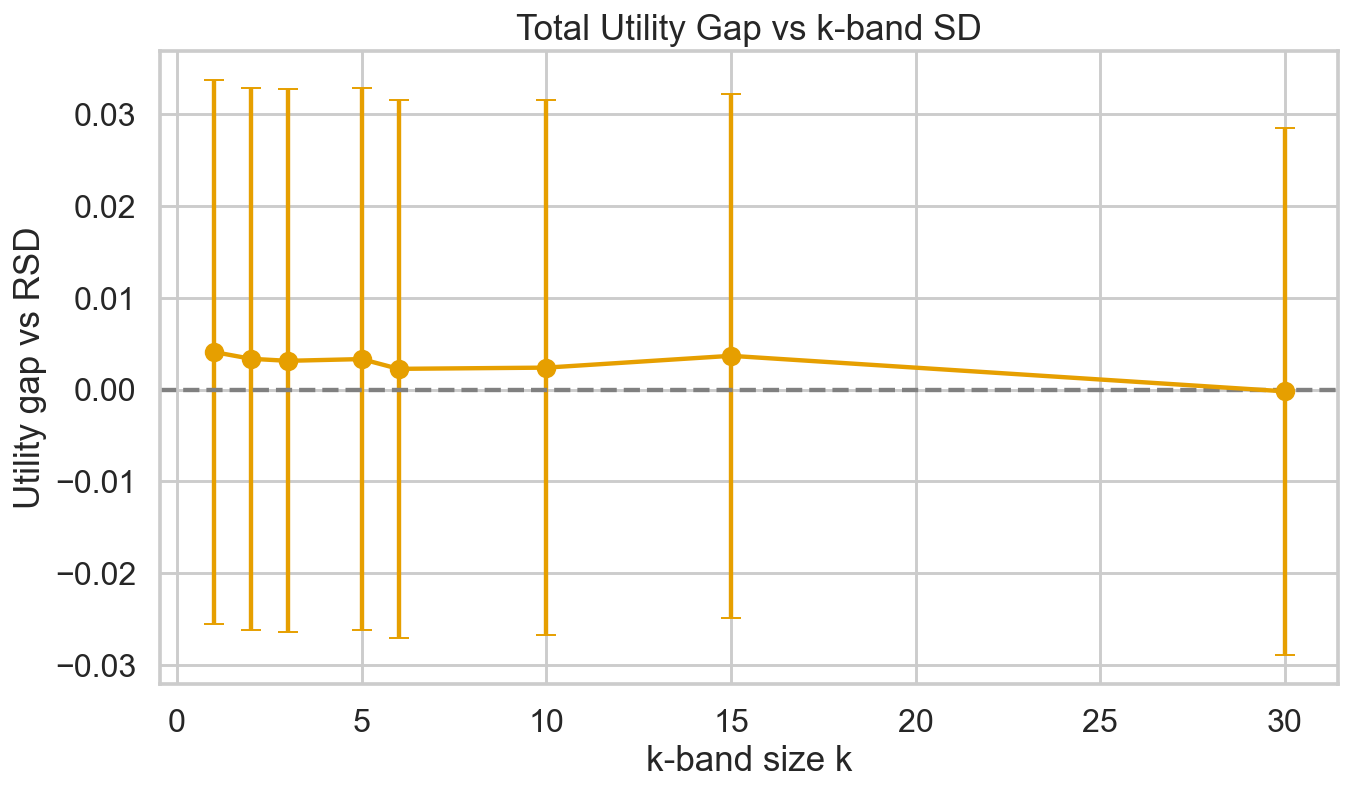

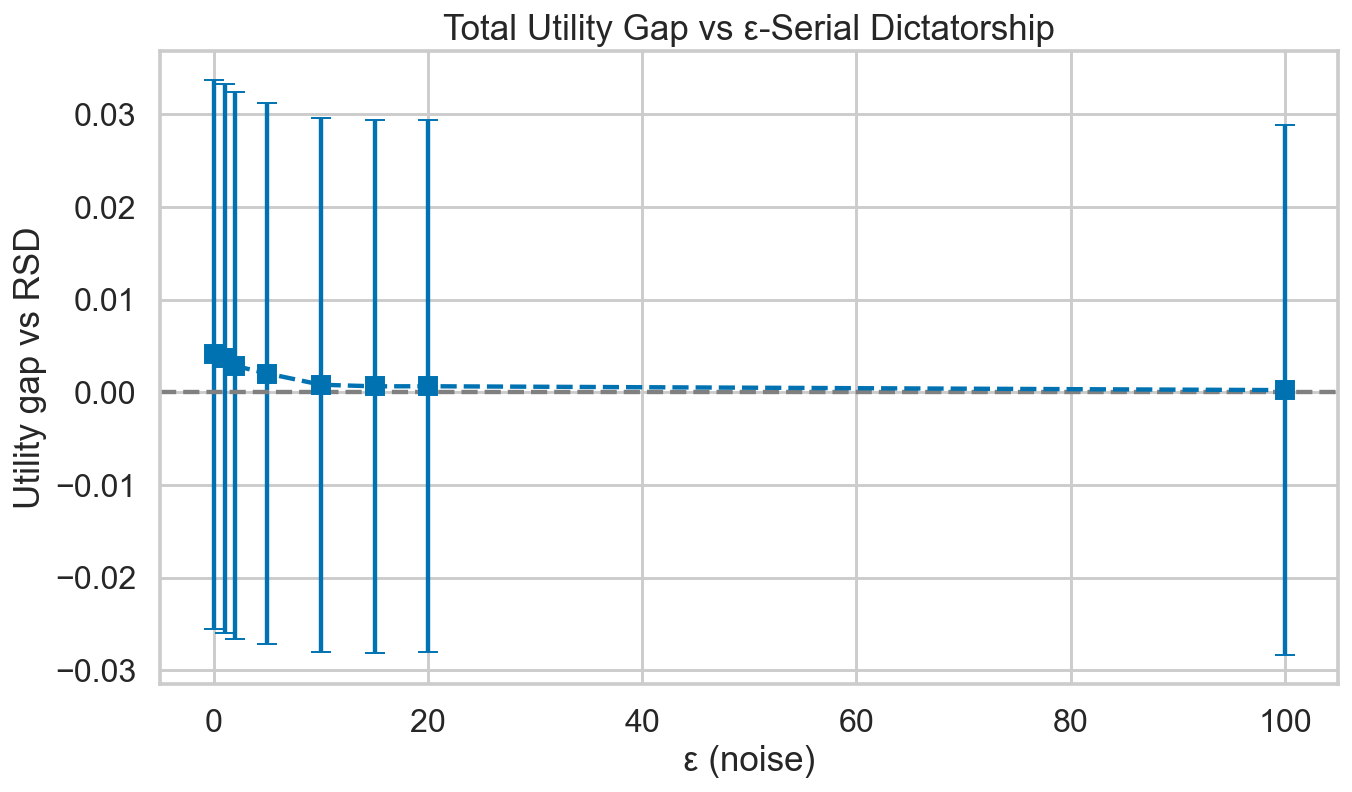

In [17]:
PM.plot_utility_gap(
    k_values, eps_values,
    util_gap_k, util_gap_eps
)


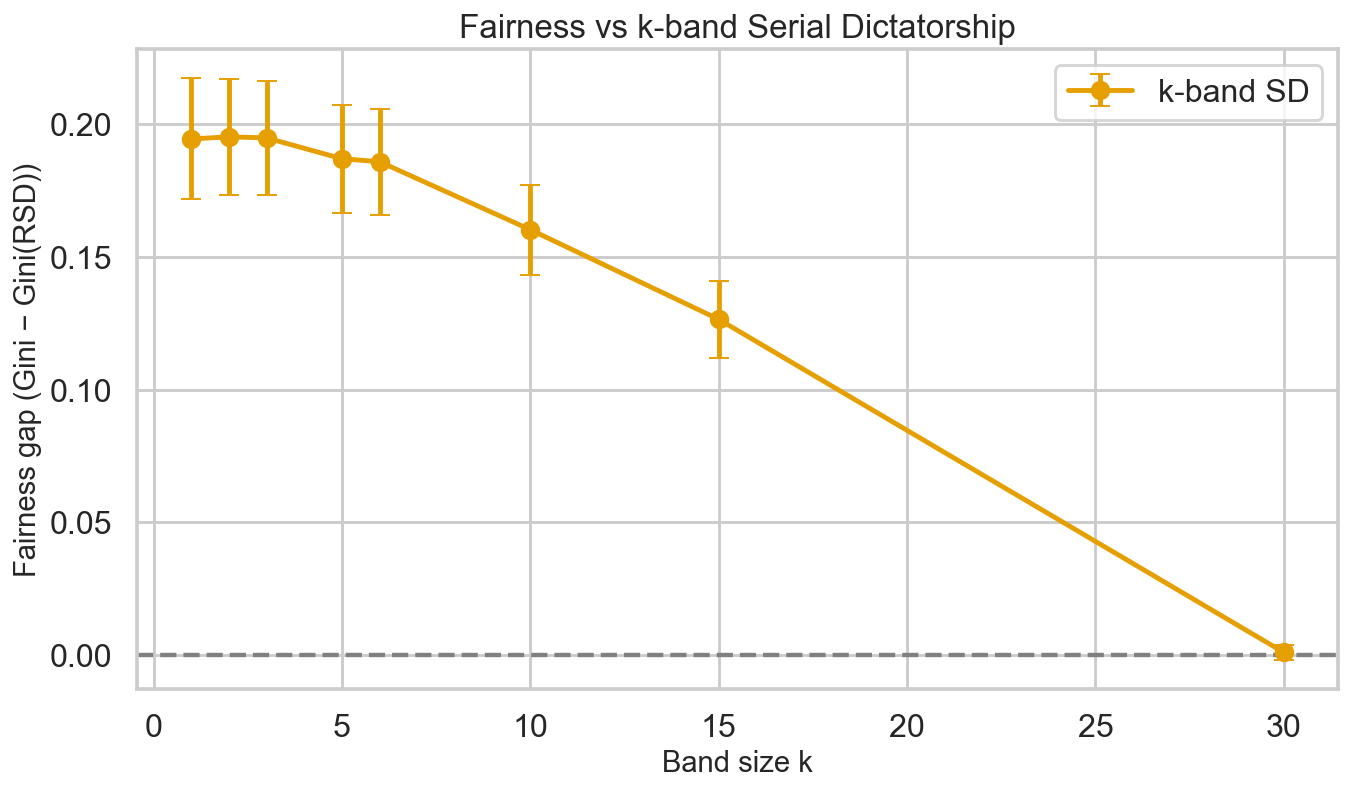

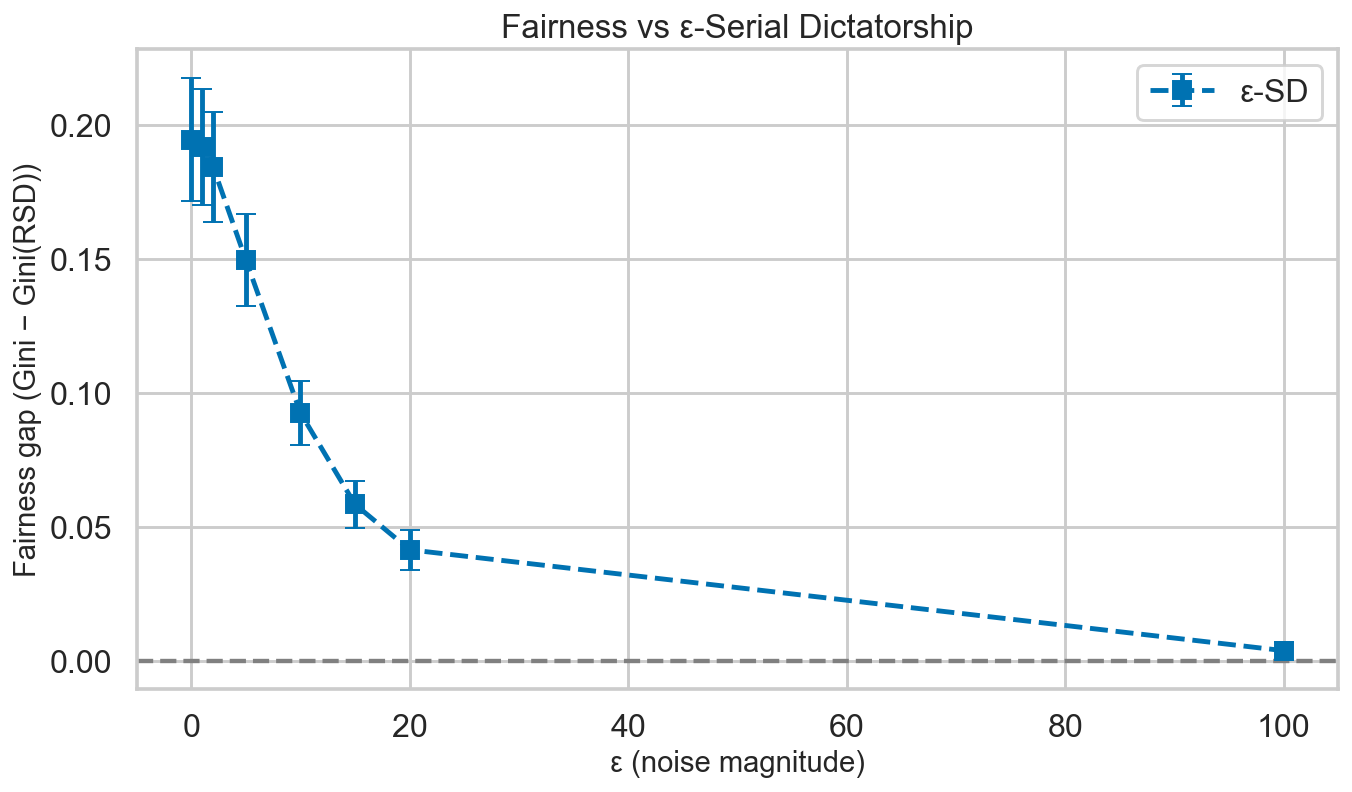

In [18]:
# example: compute SE for fairness
PM.plot_fairness_k(k_values, mean_gap_k, se_gap_k)
PM.plot_fairness_eps(eps_values, mean_gap_eps, se_gap_eps)


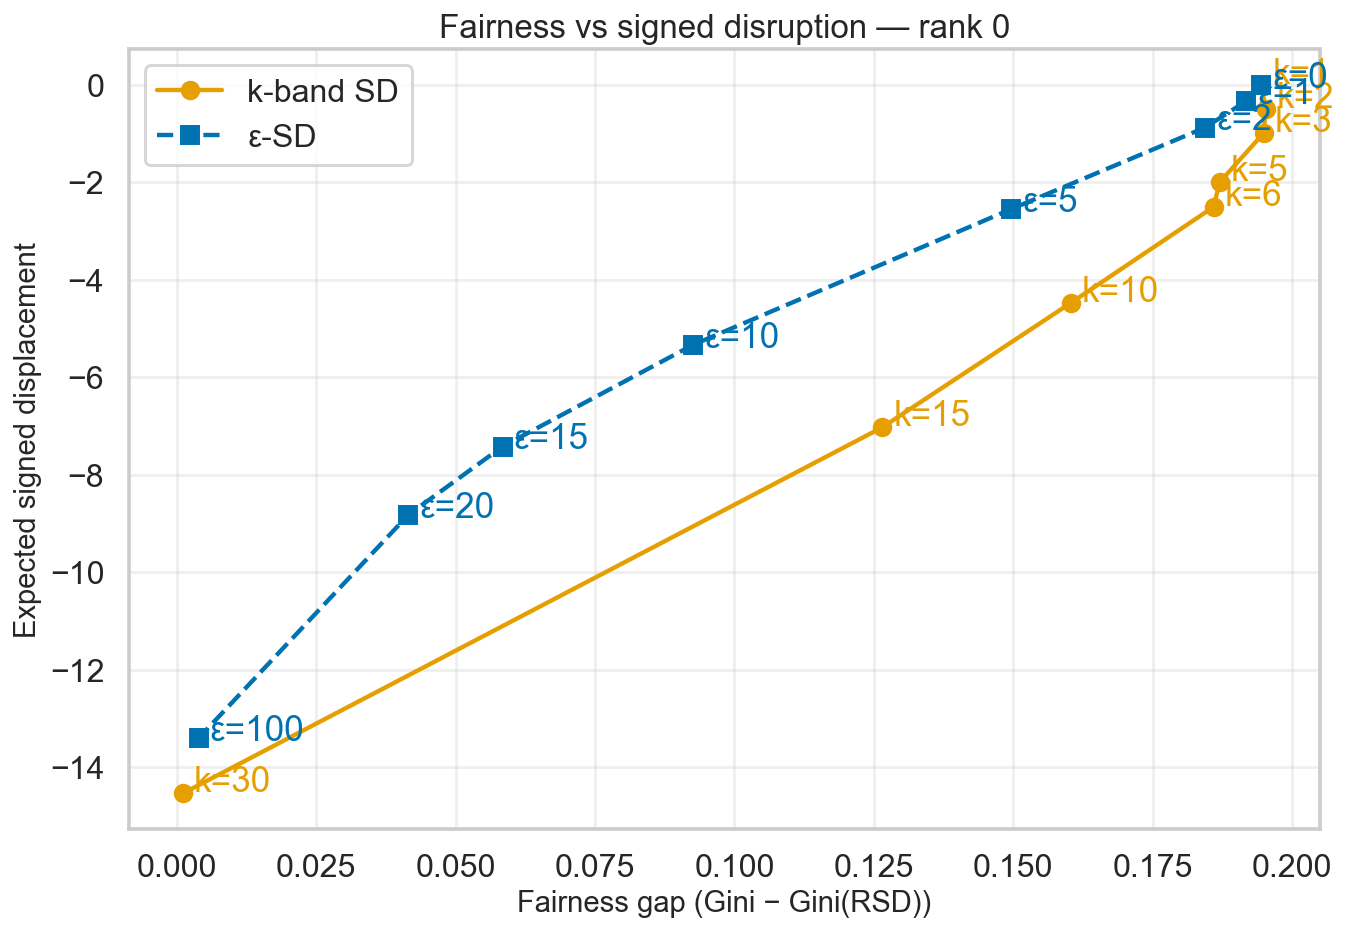

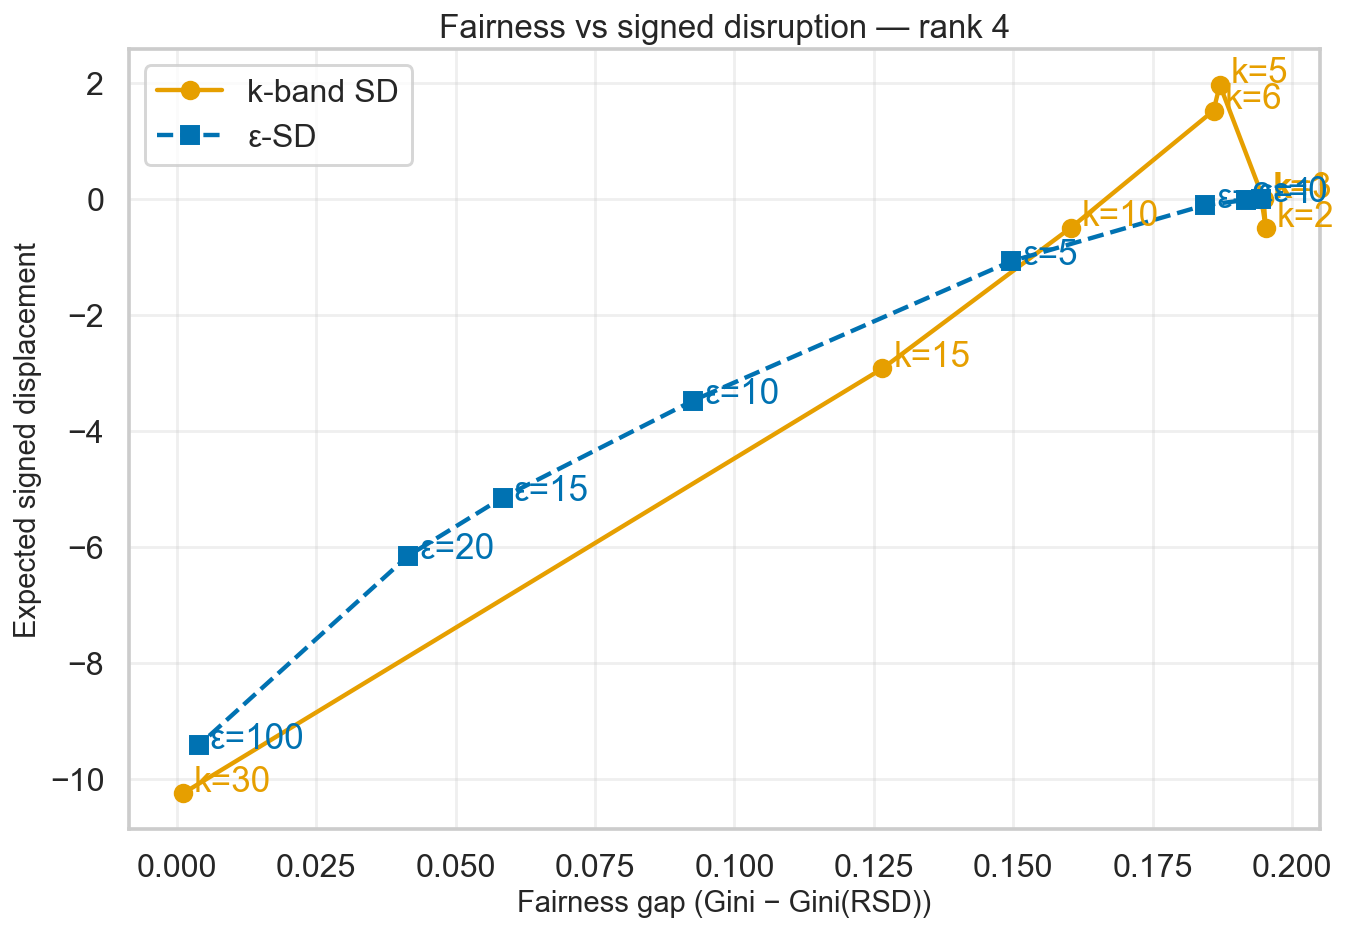

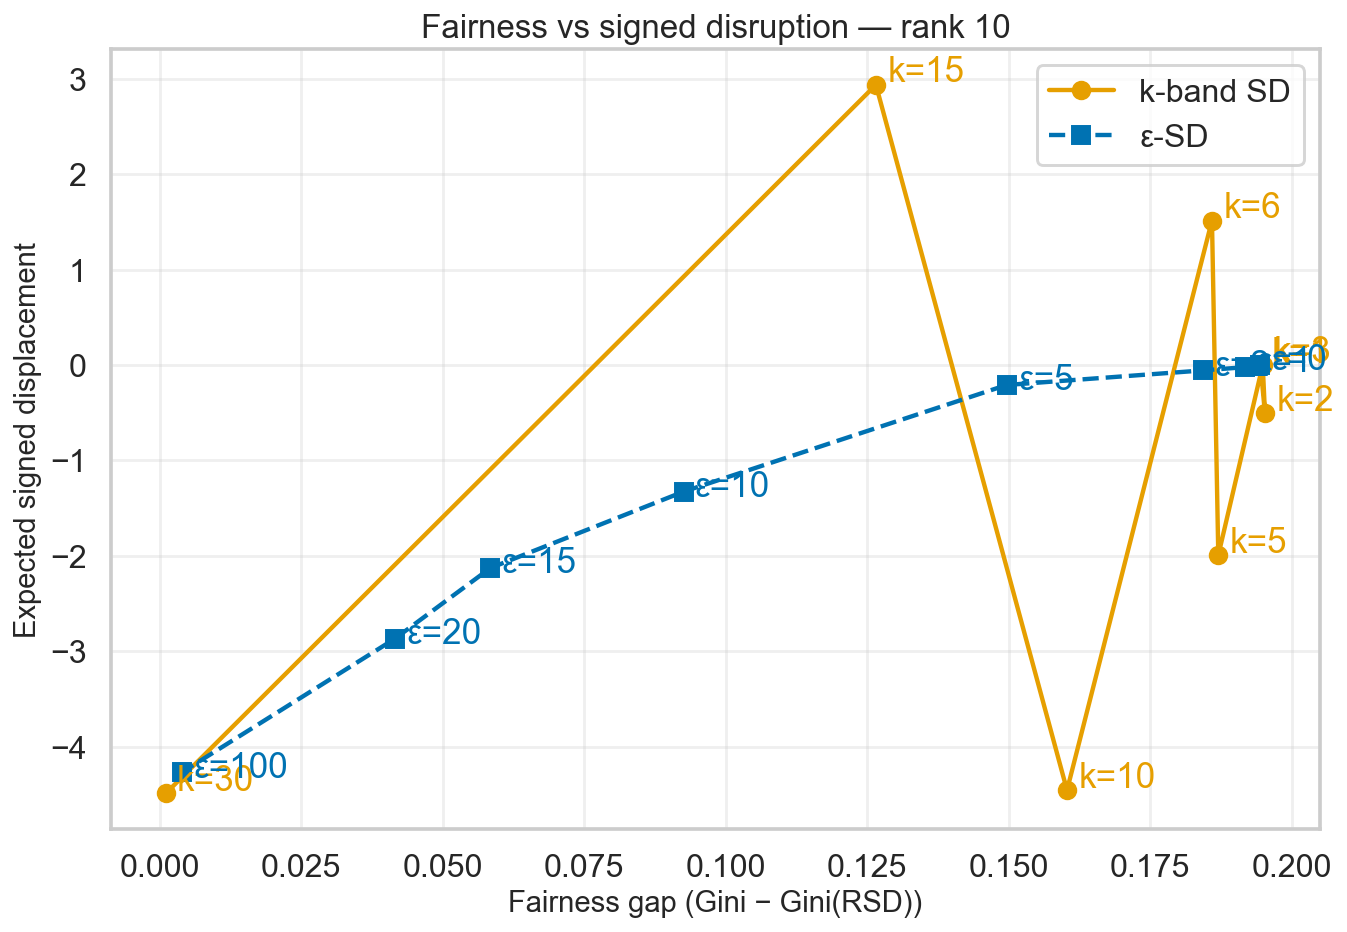

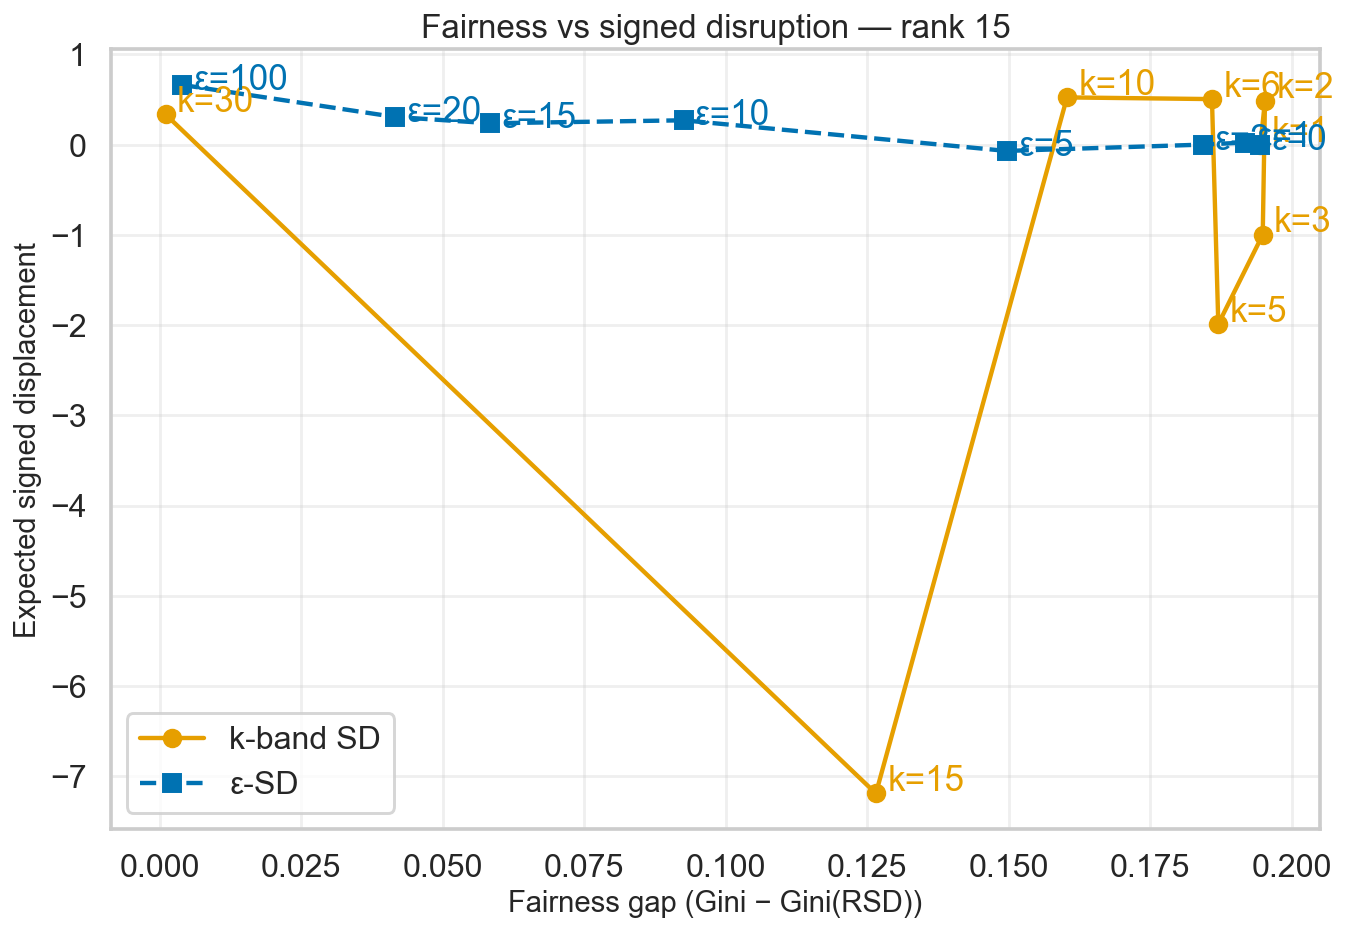

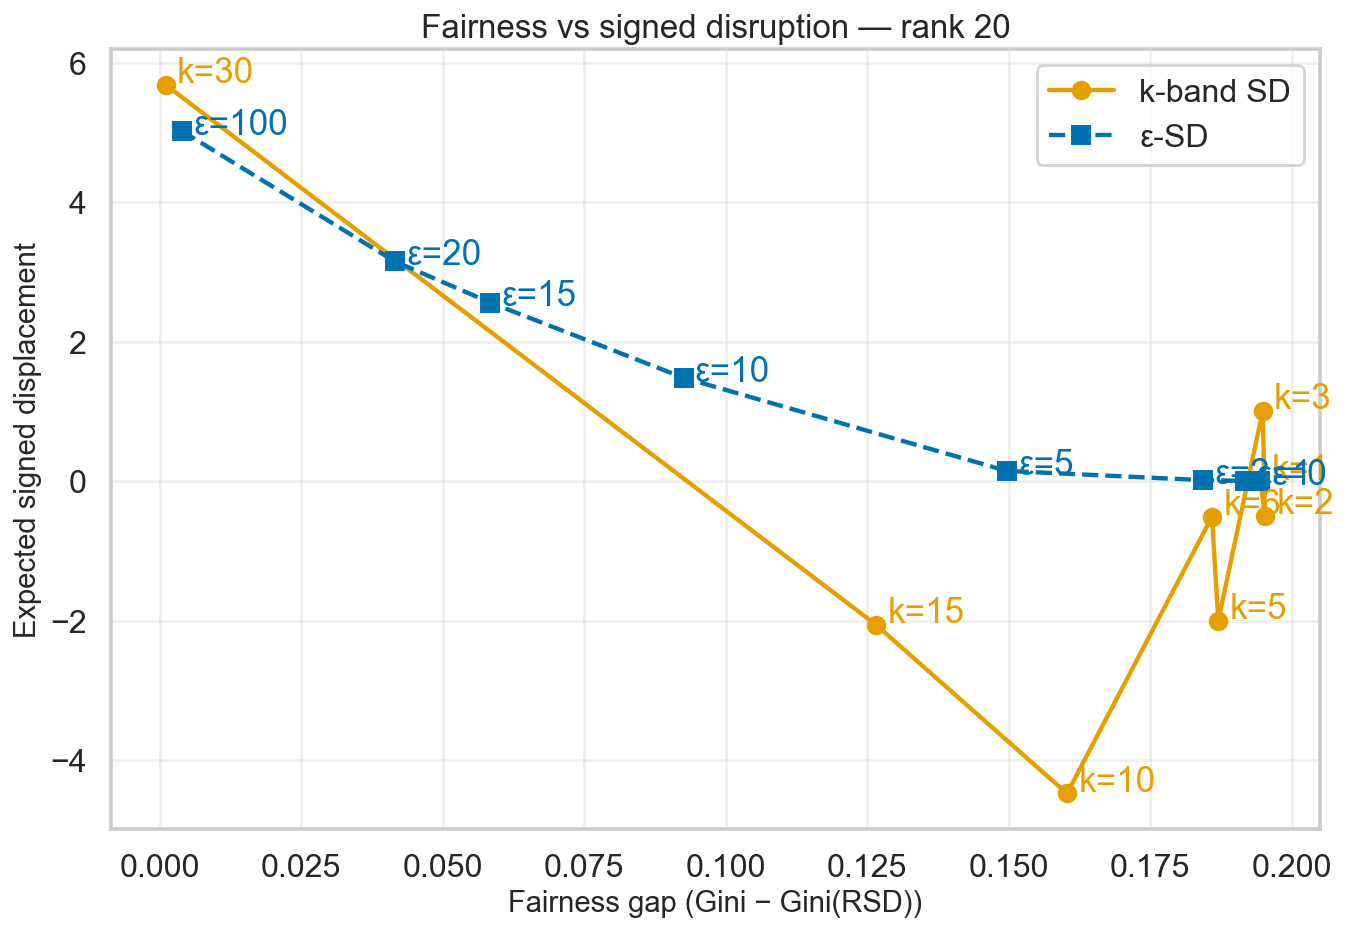

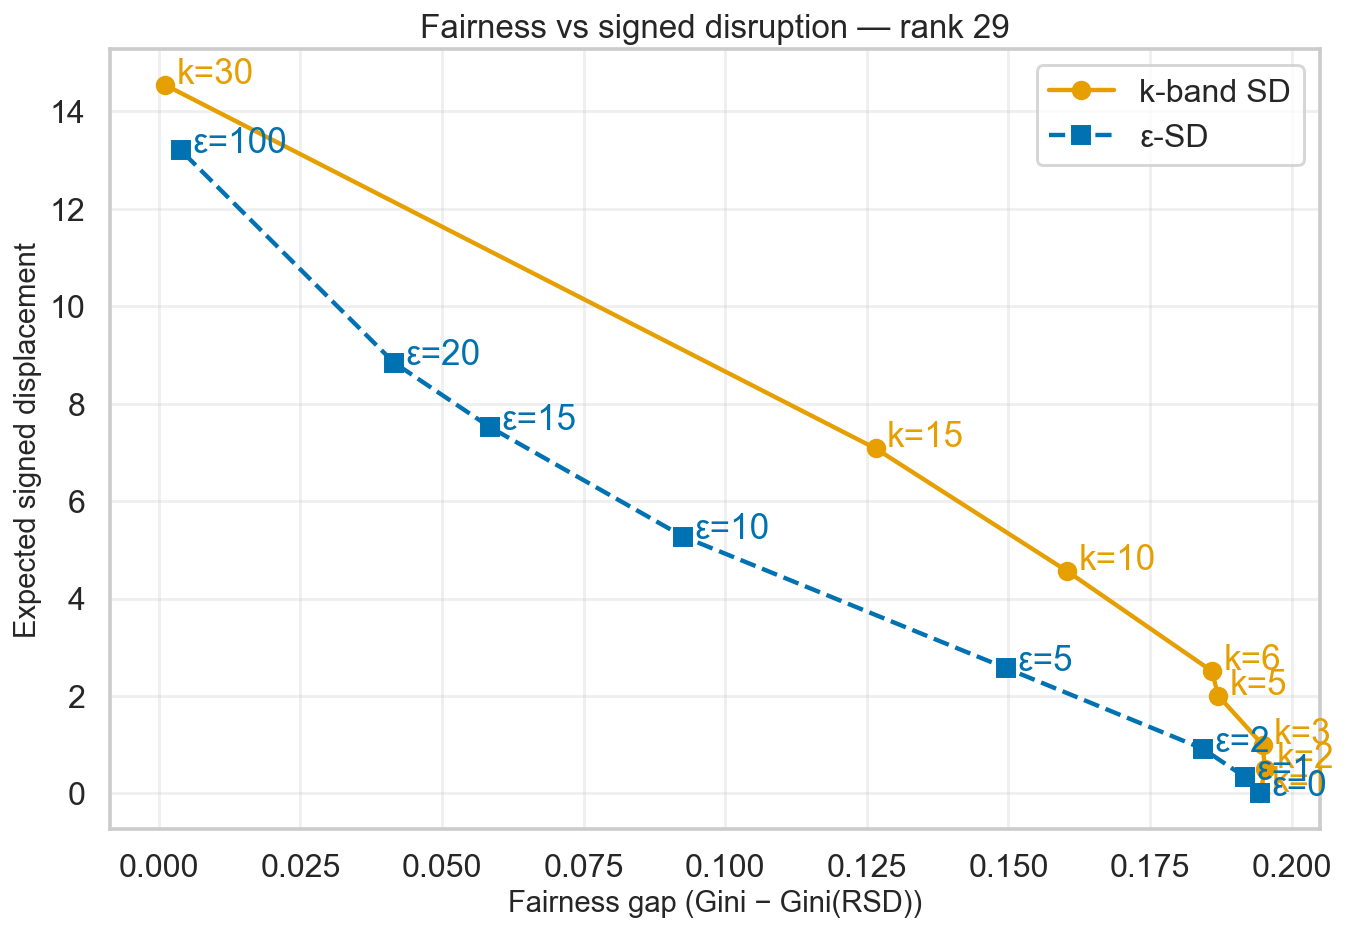

In [19]:
ranks_to_plot = [0, 4, 10, 15, 20, 29]

for r in ranks_to_plot:
    PM.plot_frontier(
        rank_i=r,
        k_values=k_values,
        eps_values=eps_values,
        mean_gap_k=mean_gap_k,
        mean_gap_eps=mean_gap_eps,
        disruption=disruption,
        signed=True
    )
